In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as r
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

(1797, 64)


<Figure size 432x288 with 0 Axes>

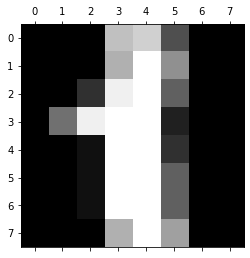

In [2]:
digits = load_digits()
print(digits.data.shape) 
plt.gray() 
plt.matshow(digits.images[1]) 
plt.show()

In [3]:
X_scale = StandardScaler()
X = X_scale.fit_transform(digits.data)
X[0,:]

array([ 0.        , -0.33501649, -0.04308102,  0.27407152, -0.66447751,
       -0.84412939, -0.40972392, -0.12502292, -0.05907756, -0.62400926,
        0.4829745 ,  0.75962245, -0.05842586,  1.12772113,  0.87958306,
       -0.13043338, -0.04462507,  0.11144272,  0.89588044, -0.86066632,
       -1.14964846,  0.51547187,  1.90596347, -0.11422184, -0.03337973,
        0.48648928,  0.46988512, -1.49990136, -1.61406277,  0.07639777,
        1.54181413, -0.04723238,  0.        ,  0.76465553,  0.05263019,
       -1.44763006, -1.73666443,  0.04361588,  1.43955804,  0.        ,
       -0.06134367,  0.8105536 ,  0.63011714, -1.12245711, -1.06623158,
        0.66096475,  0.81845076, -0.08874162, -0.03543326,  0.74211893,
        1.15065212, -0.86867056,  0.11012973,  0.53761116, -0.75743581,
       -0.20978513, -0.02359646, -0.29908135,  0.08671869,  0.20829258,
       -0.36677122, -1.14664746, -0.5056698 , -0.19600752])

In [4]:
X[0,:].mean()

-0.015717432860408956

In [5]:
X[0,:].std()

0.7608175275596868

In [6]:
y = digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [7]:
def convert_y_to_vect(y):
    y_vect = np.zeros((len(y), 10))
    for i in range(len(y)):
        y_vect[i, y[i]] = 1
    return y_vect

In [8]:
y_v_train = convert_y_to_vect(y_train)
y_v_test = convert_y_to_vect(y_test)
y_train[0], y_v_train[0]

(6, array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]))

In [9]:
nn_structure = [64, 30, 10]

In [10]:
def f(x):
    return 1 / (1 + np.exp(-x))
def f_deriv(x):
    return f(x) * (1 - f(x))

In [11]:
def setup_and_init_weights(nn_structure):
    W = {}
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l], nn_structure[l-1]))
        b[l] = r.random_sample((nn_structure[l],))
    return W, b

In [12]:
def init_tri_values(nn_structure):
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)):
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        tri_b[l] = np.zeros((nn_structure[l],))
    return tri_W, tri_b

In [13]:
def feed_forward(x, W, b):
    h = {1: x}
    z = {}
    for l in range(1, len(W) + 1):
        # if it is the first layer, then the input into the weights is x, otherwise, 
        # it is the output from the last layer
        if l == 1:
            node_in = x
        else:
            node_in = h[l]
        z[l+1] = W[l].dot(node_in) + b[l] # z^(l+1) = W^(l)*h^(l) + b^(l)  
        h[l+1] = f(z[l+1]) # h^(l) = f(z^(l)) 
    return h, z

In [14]:
def calculate_out_layer_delta(y, h_out, z_out):
    # delta^(nl) = -(y_i - h_i^(nl)) * f'(z_i^(nl))
    return -(y-h_out) * f_deriv(z_out)

def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    return np.dot(np.transpose(w_l), delta_plus_1) * f_deriv(z_l)

In [15]:
def train_nn(nn_structure, X, y, iter_num=3000, alpha=0.25):
    W, b = setup_and_init_weights(nn_structure)
    cnt = 0
    m = len(y)
    avg_cost_func = []
    print('Starting gradient descent for {} iterations'.format(iter_num))
    while cnt < iter_num:
        if cnt%1000 == 0:
            print('Iteration {} of {}'.format(cnt, iter_num))
        tri_W, tri_b = init_tri_values(nn_structure)
        avg_cost = 0
        for i in range(len(y)):
            delta = {}
            # perform the feed forward pass and return the stored h and z values, to be used in the
            # gradient descent step
            h, z = feed_forward(X[i, :], W, b)
            # loop from nl-1 to 1 backpropagating the errors
            for l in range(len(nn_structure), 0, -1):
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y[i,:], h[l], z[l])
                    avg_cost += np.linalg.norm((y[i,:]-h[l]))
                else:
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l])
                    # triW^(l) = triW^(l) + delta^(l+1) * transpose(h^(l))
                    tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(h[l][:,np.newaxis])) 
                    # trib^(l) = trib^(l) + delta^(l+1)
                    tri_b[l] += delta[l+1]
        # perform the gradient descent step for the weights in each layer
        for l in range(len(nn_structure) - 1, 0, -1):
            W[l] += -alpha * (1.0/m * tri_W[l])
            b[l] += -alpha * (1.0/m * tri_b[l])
        # complete the average cost calculation
        avg_cost = 1.0/m * avg_cost
        avg_cost_func.append(avg_cost)
        cnt += 1
    return W, b, avg_cost_func

In [16]:
W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train)

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


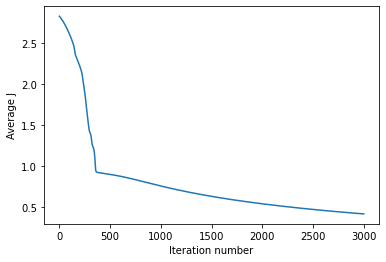

In [17]:
plt.plot(avg_cost_func)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()